<a href="https://colab.research.google.com/github/elliemci/vision-transformer-models/blob/main/object_detection/damage_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multi-class Constructions Defect Detection with Deformable DETR

In [ ]:
!pip install roboflow2huggingface

In [ ]:
!pip install huggingface_hub

In [ ]:
!pip install -q datasets transformers evaluate timm

In [ ]:
!pip install --upgrade transformers

In [ ]:
!pip install -U albumentations

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/ColabNotebooks/ExplainableAI/object_detection

Mounted at /content/drive
/content/drive/MyDrive/ColabNotebooks/ExplainableAI/object_detection


Multiple open-source images and annotations of crack and building defect image datasets are merged into a multi-class object detection image dataset, used to train a transformer-based deformable DETR to identify cracks and other types of building defects.


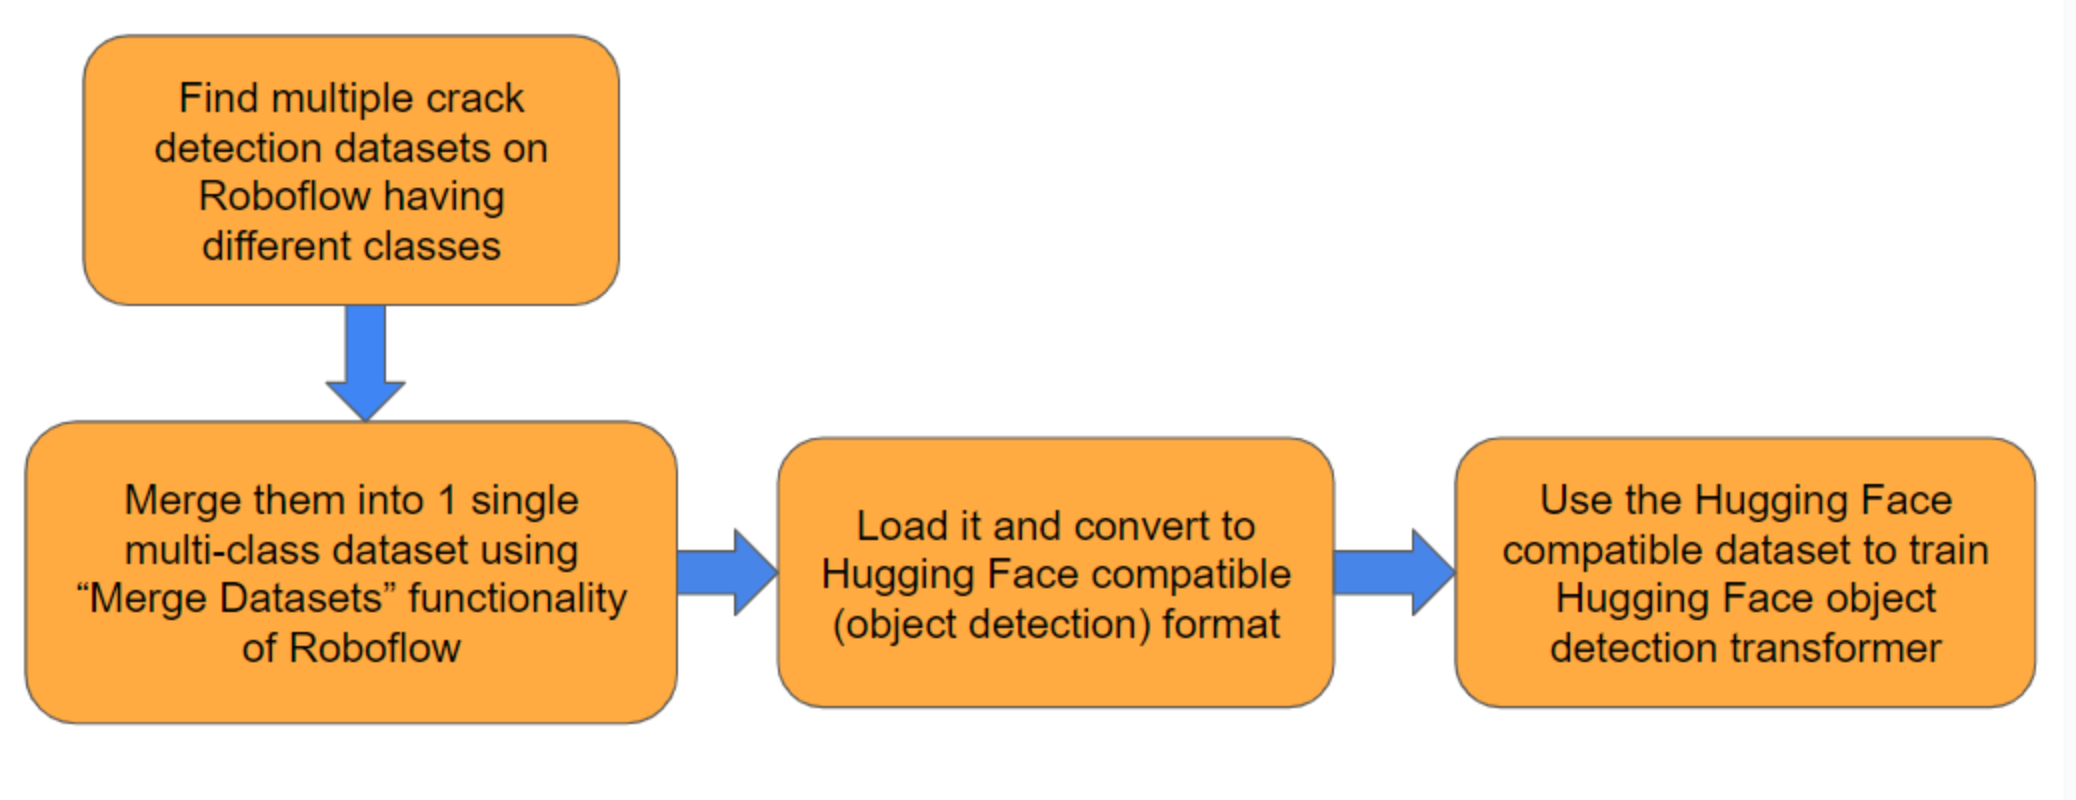

In [ ]:
from IPython.display import Image, display
display(Image(filename='/content/drive/MyDrive/ColabNotebooks/ExplainableAI/object_detection/defect_detection.png'))

## 1. Create a multi-class object detection dataset

Merging dataset converting anotations into COCO json format, understanding the structure of annotations, images and classes, applying preprocessing and standardization step and noramlizing the annotations if different annotation formats ensuring that class labels are consistient across datasets

### Create repository on Huggingface Hub

In [ ]:
from huggingface_hub import create_repo

create_repo("building_damages", repo_type = "dataset", private=True)

### Transfer Roboflow dataset to Huggingface repository

In [ ]:
from roboflow2huggingface import roboflow_to_huggingface_pipeline
from google.colab import userdata

#userdata.get('roboflow_api_key')
#userdata.get('huggingface_hub_access_token')

rf_api_key = input('Enter your Roboflow API key: ')
hf_token = input('Enter your Hugging Face write token: ')

# create a project on Roboflow, connect to a building cracks dataset on Roboflow
# and export dataset to Hugging Face dataset account
roboflow_to_huggingface_pipeline(
    roboflow_universe_url = 'https://universe.roboflow.com/elliemci/building-damages-nnk2b/dataset/2',#url of View on Universe
    roboflow_api_key = rf_api_key,  #'roboflow_api_key',
    hf_dataset_id = 'elliemci/building_damages',
    hf_write_token = hf_token #'huggingface_hub_access_token'
)

## 2. Load and Visualize Dataset

In [ ]:
from google.colab import userdata
from datasets import load_dataset
from huggingface_hub import login

userdata.get('huggingface_hub_access_token')
login('huggingface_hub_access_token')

# load dataset from Hugging Face hub
ds = load_dataset("elliemci/building_damages", name="full", trust_remote_code=True)

README.md:   0%|          | 0.00/2.70k [00:00<?, ?B/s]

building_damages.py:   0%|          | 0.00/6.17k [00:00<?, ?B/s]

train.zip:   0%|          | 0.00/73.1M [00:00<?, ?B/s]

valid.zip:   0%|          | 0.00/17.0M [00:00<?, ?B/s]

test.zip:   0%|          | 0.00/8.04M [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

### Display data content

In [ ]:
ds

DatasetDict({
    train: Dataset({
        features: ['image_id', 'image', 'width', 'height', 'objects'],
        num_rows: 5255
    })
    validation: Dataset({
        features: ['image_id', 'image', 'width', 'height', 'objects'],
        num_rows: 1266
    })
    test: Dataset({
        features: ['image_id', 'image', 'width', 'height', 'objects'],
        num_rows: 736
    })
})

In [ ]:
import random

idx = random.randint(0, len(ds['train']))

# data random sample content
example = ds['train'][idx]
example


### Class names to numerical labels

In [ ]:
# get unique category IDs
unique_category_ids = set()
for split in ds:  # iterate through 'train', 'test'
    for example in ds[split]:
        unique_category_ids.update(example['objects']['category'])

# create mappings between category indices and labels
id2label = {
    i: feature
    for i, feature in enumerate(ds['train'].features['objects'].feature['category'].names)}
label2id = {v: k for k, v in id2label.items()}

print(f"ids to labels mapping: {id2label}")
print(f"labels to ids mapping: {label2id}")
print()
# print category names
print("Object Category Names:")
for category_id in unique_category_ids:
    category_name = id2label.get(category_id, "Unknown")  # handle unknown IDs
    print(f"- {category_name}")

ids to labels mapping: {0: 'combined damage', 1: 'flexural', 2: 'minorrotation', 3: 'moderaterotation', 4: 'severerotation', 5: 'shear', 6: 'undamage', 7: 'cracks', 8: 'water'}
labels to ids mapping: {'combined damage': 0, 'flexural': 1, 'minorrotation': 2, 'moderaterotation': 3, 'severerotation': 4, 'shear': 5, 'undamage': 6, 'cracks': 7, 'water': 8}

Object Category Names:
- combined damage
- flexural
- minorrotation
- moderaterotation
- severerotation
- shear
- undamage
- cracks
- water


### Display an image overlaid with object annotations

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

def display_annotated_image(example, id2label):
  # display image with detected object category names
  print()
  plt.imshow(example['image'])
  plt.axis("off")

  # draw bounding boxes and category labels
  ax = plt.gca()

  # a loop though each detected object bounding box
  for i in range(len(example['objects']['bbox'])):
    bbox = example['objects']['bbox'][i]
    x, y, w, h = bbox
    rect = Rectangle((x, y), w, h, linewidth=2, edgecolor='r', facecolor='none')

    ax.add_patch(rect)
    category_id = example['objects']['category'][i]
    category_name = id2label.get(category_id, "Unknown")
    plt.text(x, y, category_name, color='r', fontsize=12)

plt.show()

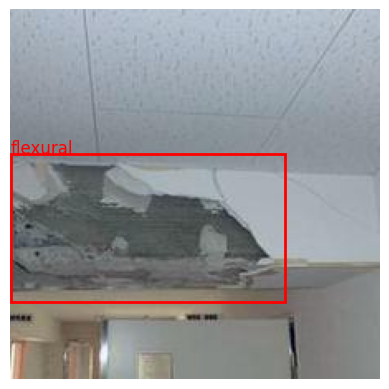

In [ ]:
display_annotated_image(example, id2label)

## 3. Pre-process dataset

In [ ]:
!pip install -U albumentations

### Resize and augment data

In [ ]:
import albumentations as A

transform = A.Compose(
    [
      A.Resize(480, 480),
      A.HorizontalFlip(p=0.5), # 50% chanse of horizontal flip to be applied to an image
      A.RandomBrightnessContrast(p=1.0), # 100% i.e. all images will have their brightness and contrast randomly adjusted
    ],
    # ensure bounding boxes are within image boundaries
    bbox_params=A.BboxParams(format='coco', label_fields=['category'], clip=True)
)

### Format Annotations

In [ ]:
def format_annot(image_id, categories, areas, bboxes):
  """ Convert annotations into COCO format into a dictionary containing transformed
      and augmented data for image with image identifier, list of category ids,
      list of area ids, and a list of bounding boxes coordinates."""

  annotations = []

  for i in range(0, len(categories)):
    new_ann = {
            "image_id": image_id,
            "category_id": categories[i],
            "isCrowd": 0,
            "area": areas[i],
            "bbox": list(bboxes[i]),
        }
    annotations.append(new_ann)

  return annotations

### Load Deformable DETR

#### Instantiate Image Processor

In [ ]:
from transformers import AutoImageProcessor, DeformableDetrForObjectDetection

checkpoint = "facebook/deformable-detr-box-supervised"

image_processor = AutoImageProcessor.from_pretrained(checkpoint)
model = DeformableDetrForObjectDetection.from_pretrained(
    checkpoint,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True,
)

### Append images and annotations into lists and pass them though image processor

In [ ]:
import numpy as np

def transform_augment(example):
  """ The function takes an example dictionary as input, which contains image data
      and object annotations, and it transformes them with a pre-defined transform
      function, iterating through each image and formatting annotations in the example."""

  image_id = example['image_id']
  images, bboxes, areas, categories = [], [], [], []

  for image, objects  in zip(example["image"], example["objects"]):
    # convert the image to RGB and reverse the color channel
    image = np.array(image.convert("RGB"))[:, :, ::-1]
    # aplly transformation to the image
    out = transform(image=image, bboxes=objects["bbox"], category=objects["category"])
    # append transformed and augmented data to the respective lists
    areas.append(objects["area"])
    images.append(out["image"])
    bboxes.append(out["bboxes"])
    categories.append(out["category"])
  # use list comprehention to iterate through the lists to format the annotations
  targets = [
        {"image_id": id,
         "annotations": format_annot(id, cat, ar, box)}
        for id, cat, ar, box in zip(image_id, categories, areas, bboxes)
  ]
  # pre-process with image_processor
  example = image_processor(images=images, annotations=targets, return_tensors="pt")

  return example

In [ ]:
# modify in place vs ds['train']=ds['train'].with_transform(transform_augment)
ds['train'].set_transform(transform_augment)
print(f"transformed and augmented image: {ds['train'][idx]}")

transformed and augmented image: {'pixel_values': tensor([[[0.2111, 0.2111, 0.2111,  ..., 0.2967, 0.2967, 0.2967],
         [0.2111, 0.2111, 0.2111,  ..., 0.2967, 0.2967, 0.2967],
         [0.2111, 0.2111, 0.2111,  ..., 0.2967, 0.2967, 0.2967],
         ...,
         [0.4166, 0.4166, 0.4166,  ..., 0.3823, 0.3994, 0.3994],
         [0.4166, 0.4166, 0.4166,  ..., 0.3994, 0.3994, 0.3994],
         [0.4166, 0.4166, 0.4166,  ..., 0.3994, 0.3994, 0.3994]],

        [[0.1001, 0.1001, 0.1001,  ..., 0.2052, 0.2052, 0.2052],
         [0.1001, 0.1001, 0.1001,  ..., 0.2052, 0.2052, 0.2052],
         [0.1001, 0.1001, 0.1176,  ..., 0.2052, 0.2052, 0.2052],
         ...,
         [0.2927, 0.2927, 0.2927,  ..., 0.4153, 0.4328, 0.4328],
         [0.2927, 0.2927, 0.2927,  ..., 0.4153, 0.4328, 0.4328],
         [0.2927, 0.2927, 0.2927,  ..., 0.4153, 0.4328, 0.4328]],

        [[0.3568, 0.3568, 0.3568,  ..., 0.4265, 0.4265, 0.4265],
         [0.3568, 0.3568, 0.3568,  ..., 0.4265, 0.4265, 0.4265],
        

## 4. Batch Images and masks

### Pad Images, construct pixel masks and create batches

In [ ]:
def collate_func(batch):
  """ Batching the training data preparing it in format expected by the model.
  It handles padding images, creates pixel masks combining them with labels into
  a dictionary batch."""

  # extract the pizel values and the ground truth annoataions
  pixel_values = [item['pixel_values'] for item in batch]
  # use image procesor to pad and create a pixel mask
  encoding = image_processor.pad(pixel_values, return_tensors="pt")
  # extract labels from each item in the batch
  labels = [item["labels"] for item in batch]

  batch = {}
  # combine image data, pixel masks, and labels into a single dictionary
  batch['pixel_values'] = encoding['pixel_values']
  batch['pixel_mask'] = encoding['pixel_mask']
  batch['labels'] = labels

  return batch

## 5. Train deformable DETR to detect construction damages

### Define training hyperparameters

In [ ]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir = "building_damages",
    per_device_train_batch_size = 8,
    num_train_epochs = 10,
    fp16 = True,
    save_steps = 1000,
    logging_steps = 10,
    learning_rate = 1e-5,
    weight_decay = 1e-4,
    save_total_limit = 2,
    remove_unused_columns = False,
    push_to_hub = True,
    save_safetensors=False
)

### Set training parameters

In [ ]:
from transformers import Trainer # high-level API for training pytorch models

trainer = Trainer(
    model = model,
    args = training_args,
    data_collator = collate_func,
    train_dataset = ds["train"],
    processing_class = image_processor,
)

### Pass training arguments to Trainer

wandb provides a web-based dashboard to visualize training metrics, compare experiments, and track model's performance.

In [ ]:
trainer.train()
# deploy a W&B server locally: https://wandb.me/wandb-server

In [ ]:
model.save_pretrained("deformDetr_damage_detection")
# save the image processor configuration to model directory
image_processor.save_pretrained("deformDetr_damage_detection")

In [ ]:
#Upload the trained model to Huggingface Hub
trainer.push_to_hub(repo_id="elliemci/deformDetr_damage_detection")

## 6. Run Inference

In [ ]:
from transformers import DeformableDetrForObjectDetection, AutoImageProcessor

trained_model = DeformableDetrForObjectDetection.from_pretrained("deformDetr_damage_detection")
image_processor = AutoImageProcessor.from_pretrained("deformDetr_damage_detection")

id2label = trained_model.config.id2label
label2id = trained_model.config.label2id

### Load a random image

In [ ]:
import random

# slect a random test image
rand_idx = random.randint(0, len(ds["test"]) - 1)

image = ds["test"][rand_idx]["image"]
# ground truth bounding boxes for objects in image
box_t =  ds["test"][rand_idx]["objects"]["bbox"]
box_t = [item for sublist in box_t for item in sublist]

### Perform Inference

In [ ]:
def run_inference(image, model, image_processor, id2label, threshold=0.2):
    """
    Performs object detection inference on an image using the provided model
    and image processor, returns a list of detection results, each containing
    the detected object's label, confidence score, and bounding box.
    """
    with torch.inference_mode():  # Use inference mode for faster inference
        inputs = image_processor(images=image, return_tensors="pt")
        outputs = model(**inputs)
        target_sizes = torch.tensor([image.size[::-1]])
        results = image_processor.post_process_object_detection(outputs, threshold=threshold, target_sizes=target_sizes)[0]

    detections = []
    for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
        box = [round(i, 2) for i in box.tolist()]
        detections.append({
            "label": id2label[label.item()],
            "confidence": round(score.item(), 3),
            "box": box
        })

    return detections

In [ ]:
detections = run_inference(image, trained_model, image_processor, id2label)

for detection in detections:
  print(f"Detected {detection['label']} with confidence {detection['confidence']} at location {detection['box']}")

In [ ]:
def visualize_detections(image, detections, id2label):
    """
    Visualizes object detection results on the input image.
    """
    # Create a figure and axes
    fig, ax = plt.subplots(1)
    # Display the image
    ax.imshow(image)
    # Turn off axis ticks and labels
    ax.axis('off')

    # Iterate through detections and draw bounding boxes and labels
    for detection in detections:
        label = detection['label']
        confidence = detection['confidence']
        box = detection['box']
        x_min, y_min, x_max, y